In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from dataset_helpers import filelist_reader

In [2]:
# image path
root = '../dataset/MNIST_224X224_3'
noise_image = 'noise.jpg'
test_data = 'test'
annot_file = 'pairs_test.txt'

# save path
# occ_test = 'test_occ'
occ_test = 'test_occ_black_exp'

In [3]:
def load_occluders(root, img_path):
    img = Image.open(os.path.join(root, img_path))
    occluder = np.asarray(img)
    print(type(occluder))
    return occluder


def black_noise(size = (224, 224)):
    return np.zeros((224,224,3), dtype = np.uint8)
    
    
def resize_image(img, scale_factor):
    new_size = (int(img.shape[0] * scale_factor), int(img.shape[1] * scale_factor))
    return cv2.resize(img, new_size, fx=scale_factor, fy=scale_factor, interpolation = cv2.INTER_AREA)
    
    
def occlude_with_noise(img, occluder, shift=30):
    result = img.copy()
    img_size = np.asarray([img.shape[1], img.shape[0]])
    scale_factor = min(img_size) / 224
    
    count = 1
    
    for _ in range(count):
        # resize the occluder
        random_scale_factor = np.random.uniform(0.4, 0.6)
        occ_scale_factor = scale_factor * random_scale_factor
        occluder = resize_image(occluder, occ_scale_factor)
        
        occ_center = np.random.uniform([shift,shift], img_size-shift)
        put_occlusion(occluder, result, occ_center)
        
        return result
        
        
def put_occlusion(img_src, img_dst, center):
    '''
    Put source image to destination image at specified center
    '''
    src_size = np.asarray([img_src.shape[1], img_src.shape[0]])
    dst_size = np.asarray([img_dst.shape[1], img_dst.shape[0]])
    
    # region of destination image that will be occluded
    center = center.astype(int)
    raw_start_dst = center - src_size // 2 # top left
    raw_end_dst = raw_start_dst + src_size # bottom right
    start_dst = np.clip(raw_start_dst, 0, dst_size)
    end_dst = np.clip(raw_end_dst, 0, dst_size)
    
    # region of source image to be extracted
    start_src = start_dst - raw_start_dst
    end_src = src_size +(end_dst - raw_end_dst)

    occ = img_src[start_src[1]:end_src[1], start_src[0]:end_src[0]]
    
    # occlusion
    img_dst[start_dst[1]:end_dst[1], start_dst[0]:end_dst[0]] = occ

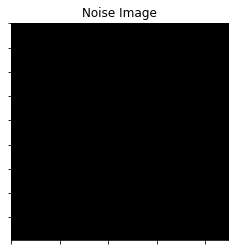

In [4]:
# show noise image

# occluder = load_occluders(root, noise_image)
occluder = black_noise()
plt.imshow(occluder)
plt.title('Noise Image')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.show()

In [5]:
# load the annotation file
image_list = filelist_reader(os.path.join(root, annot_file))
print(len(image_list))

10000


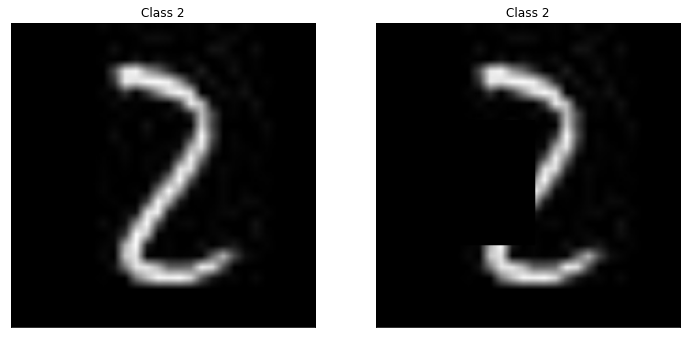

In [6]:
index = np.random.randint(0, len(image_list))

img_path, label = image_list[index]
sample_img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
occluded_img = occlude_with_noise(sample_img, occluder)

# plot the result
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(sample_img)
ax[0].set_title(f'Class {label}')
ax[1].imshow(occluded_img)
ax[1].set_title(f'Class {label}')

for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
plt.show()

In [7]:
# generate occluded test set
# occluder = load_occluders(root, noise_image)
occluder = black_noise()

for img_path, label in image_list:
    img_dir, img_file = img_path.split('/')
    
    img = np.asarray(Image.open(os.path.join(root, test_data, img_path)))
    occluded_img = occlude_with_noise(img, occluder)
    occluded_img = Image.fromarray(occluded_img)
    
    # save the image
    save_dir = os.path.join(root, occ_test, img_dir)
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    occluded_img.save(os.path.join(save_dir, img_file))